In [1]:
suppressWarnings(suppressPackageStartupMessages({
    library(tidyverse)
    library(data.table)
}))


In [188]:
mit.colors <- c(Black = "#000000", Orange = "#FF9233", Cyan = "#29D0D0", Lt.Green = "#81C57A",
Dk.Gray = "#575757", Red = "#AD2323", Blue = "#2A4BD7", Green = "#1D6914",
Brown = "#814A19", Purple = "#8126C0", Lt.Gray = "#A0A0A0", Yellow = "#FFEE33",
Pink = "#FFCDF3")

cb.colors <- c(black = "#000000", orange = "#E69F00", sky.blue = "#56B4E9",
bluish.green = "#009E73", yellow = "#F0E442", blue = "#0072B2",
vermilion = "#D55E00", reddish.purple = "#CC79A7")


In [3]:
res_d <- '/scratch/groups/mrivas/projects/PRS/private_output/202009_batch'
eval_1_df <- fread(file.path(res_d, 'snpnet.eval.1_fit_w_val.tsv')) %>% rename('GBE_ID'='#GBE_ID')
eval_2_df <- fread(file.path(res_d, 'snpnet.eval.2_refit.tsv')) %>% rename('GBE_ID'='#GBE_ID')


In [47]:
eval_2_df %>% filter(split == 'test', n_variables>0, GBE_N >= 100) -> df


In [80]:
eval_2_df %>% filter(split == 'test') %>% nrow() %>% print()
eval_2_df %>% filter(split == 'test', n_variables>0) %>% nrow() %>% print()
eval_2_df %>% filter(split == 'test', n_variables>0, GBE_N >= 100) %>% nrow() %>% print()
eval_2_df %>% filter(split == 'test', n_variables>0, GBE_N >= 100, geno_covar > if_else(family == 'binomial', .5, 0)) %>% nrow() %>% print()


[1] 2198
[1] 1874
[1] 1874
[1] 1858


In [83]:
eval_2_df %>% filter(split == 'test', n_variables>0, GBE_N >= 100, geno_covar > if_else(family == 'binomial', .5, 0)) -> tmp
tmp %>% filter(geno_delta > 0) %>% nrow() %>% print()
tmp %>% filter((geno_delta / covar) > 0.01) %>% nrow() %>% print()
tmp %>% filter((geno_delta - if_else(family == 'binomial', .5, 0)) / (covar - if_else(family == 'binomial', .5, 0)) > 0.01) %>% nrow() %>% print()
tmp %>% filter(geno_delta > 0.01) %>% nrow() %>% print()


[1] 1446
[1] 1088
[1] 844
[1] 719


In [88]:
eval_2_df %>% filter(split == 'test', n_variables>0, GBE_N >= 100, geno_covar > if_else(family == 'binomial', .5, 0), geno_delta > 0.01) -> df


In [224]:
df %>%
count(family)

family,n
<chr>,<int>
binomial,208
gaussian,511


In [134]:
df %>% count(GBE_category) %>%
arrange(-n)

GBE_category,n
<chr>,<int>
Diffusion_brain_MRI,135
Disease_outcome,124
Biomarkers,114
T1_structural_brain_MRI,72
Blood_assays,69
Anthropometry,38
Lifestyle_and_environment,35
Health_and_medical_history,32
Bone-densitometry_of_heel,23


In [500]:
options(repr.plot.width=8, repr.plot.height=4)

df %>% 
ggplot(aes(x=n_variables, fill=family)) +
geom_hline(yintercept = 0, color=mit.colors[['Lt.Gray']])+
geom_histogram(bins=30) + theme_bw() + facet_wrap(~family, scale='free') +
labs(
    title='Sparsity of the snpnet PRS models',
    x = 'Number of genetic variants in snpnet PRS model',
    y = 'Number of traits'
) + 
theme(
    title = element_text(size=16),
    legend.title = element_text(size=14),
    legend.text  = element_text(size=12),
    axis.text=element_text(size=16), 
    axis.title=element_text(size=16),
    legend.position = 'none'
) +
scale_fill_manual(breaks = c("binomial", 'gaussian'), values=c(unname(cb.colors[2]), unname(cb.colors[3]))) -> p_sparse_histo

In [501]:
ggsave('plots/p_sparse_histo.pdf', p_sparse_histo, width=12, height=6)
ggsave('plots/p_sparse_histo.png', p_sparse_histo, width=12, height=6)


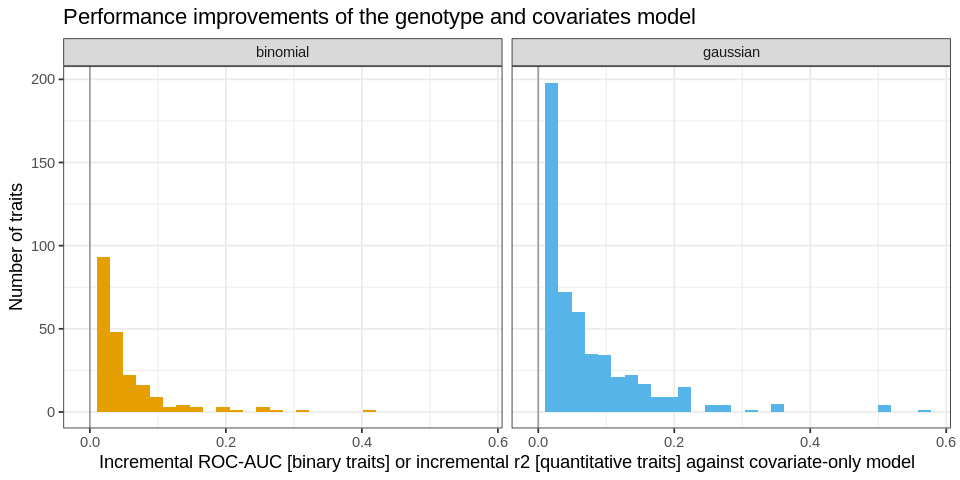

In [196]:
df %>% 
ggplot(aes(x=geno_delta, fill=family)) +
geom_vline(xintercept = 0, color=mit.colors[['Lt.Gray']])+
geom_histogram(bins=30) + theme_bw() +
facet_wrap(~family) +
labs(
    title='Performance improvements of the genotype and covariates model',
    x = 'Incremental ROC-AUC [binary traits] or incremental r2 [quantitative traits] against covariate-only model',
    y = 'Number of traits'
) + theme(legend.position = 'none') +
scale_fill_manual(breaks = c("binomial", 'gaussian'), values=c(unname(cb.colors[2]), unname(cb.colors[3])))

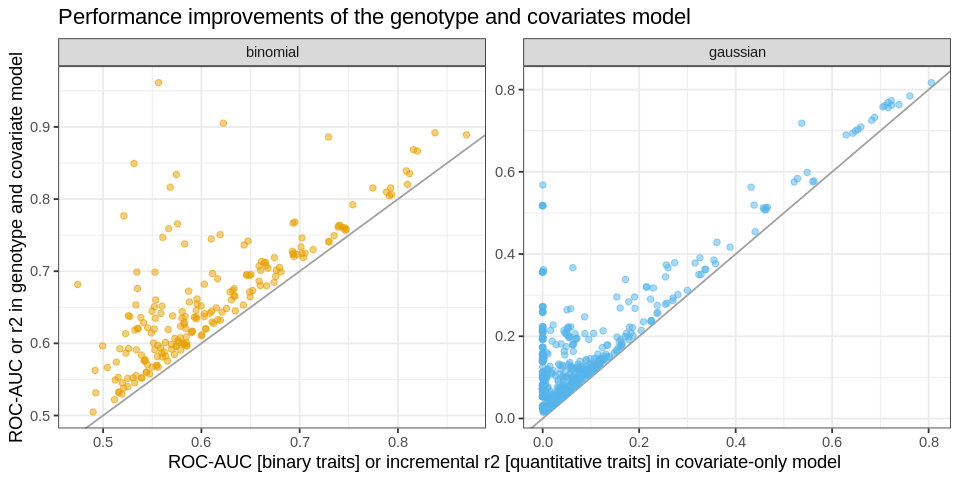

In [198]:
df %>% 
ggplot(aes(x=covar, y=geno_covar, color=family)) +
geom_abline(slope=1, intercept = 0, color = mit.colors[['Lt.Gray']]) +
geom_point(alpha=.5) + theme_bw() +
facet_wrap(~family, scales = "free") +
labs(
    title='Performance improvements of the genotype and covariates model',
    x = 'ROC-AUC [binary traits] or incremental r2 [quantitative traits] in covariate-only model',
    y = 'ROC-AUC or r2 in genotype and covariate model'
) + theme(legend.position = 'none') +
scale_color_manual(breaks = c("binomial", 'gaussian'), values=c(unname(cb.colors[2]), unname(cb.colors[3])))

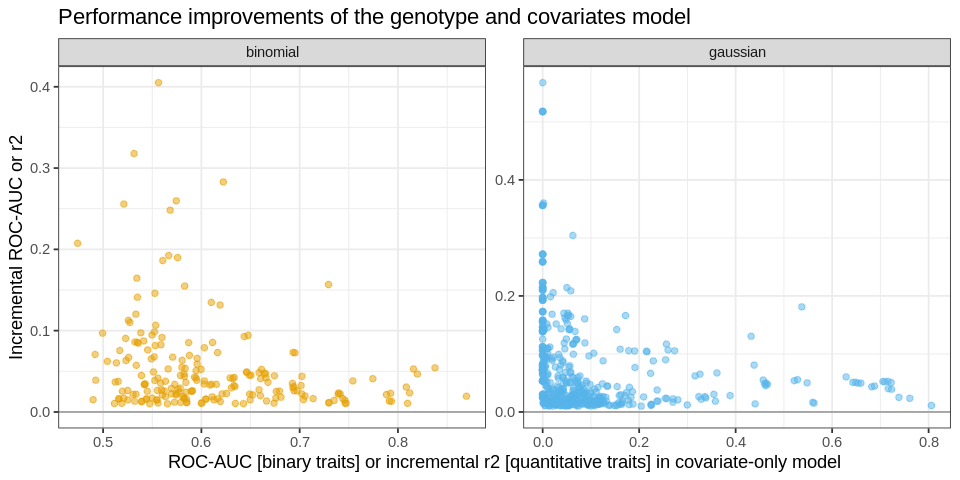

In [199]:
df %>% 
ggplot(aes(x=covar, y=geno_delta, color=family)) +
geom_hline(yintercept = 0, color=mit.colors[['Lt.Gray']])+
geom_point(alpha=.5) + theme_bw() +
facet_wrap(~family, scales = "free") +
labs(
    title='Performance improvements of the genotype and covariates model',
    x = 'ROC-AUC [binary traits] or incremental r2 [quantitative traits] in covariate-only model',
    y = 'Incremental ROC-AUC or r2'
) + theme(legend.position = 'none') +
scale_color_manual(breaks = c("binomial", 'gaussian'), values=c(unname(cb.colors[2]), unname(cb.colors[3])))


In [369]:
df %>% 
ggplot(aes(x=n_variables, y=geno_delta, color=family)) +
geom_hline(yintercept = 0, color=mit.colors[['Lt.Gray']])+
geom_point(alpha=.5) + theme_bw() +
facet_wrap(~family, scales = "free") +
labs(
    title = 'Sparsity of the snpnet PRS model and their predictive performance',
    x = 'Number of genetic variants in PRS model',
    y = 'Incremental ROC-AUC or r2'
) + theme(legend.position = 'none') +
scale_color_manual(breaks = c("binomial", 'gaussian'), values=c(unname(cb.colors[2]), unname(cb.colors[3]))) -> p_sparse


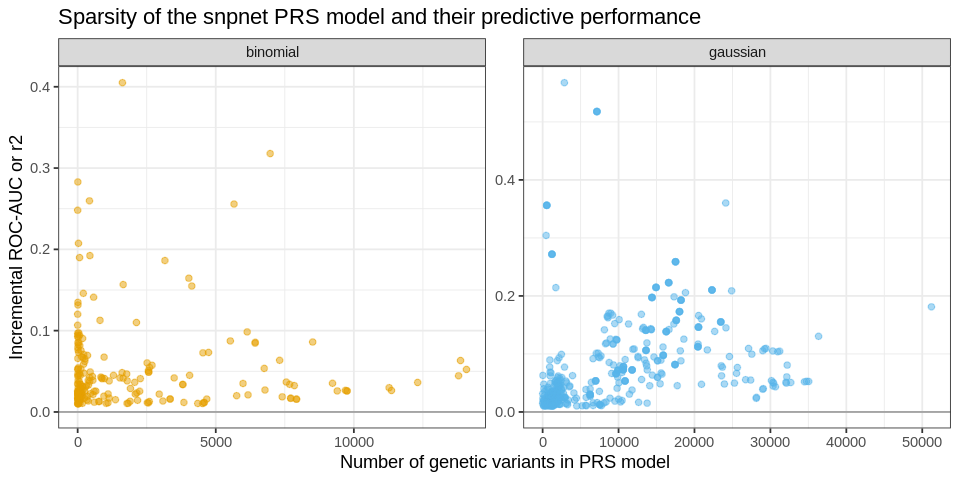

In [371]:
options(repr.plot.width=8, repr.plot.height=4)
p_sparse

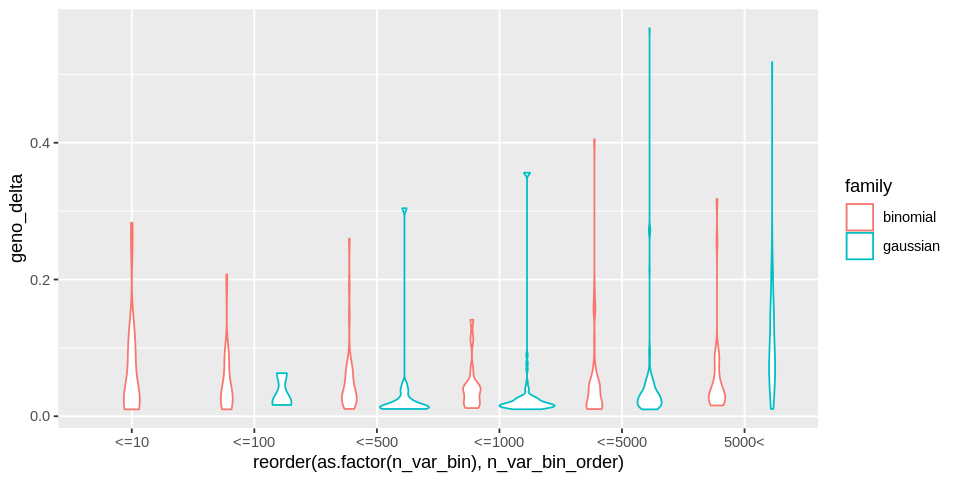

In [447]:
df %>%
mutate(
    n_var_bin = if_else(
        n_variables <= 10, '<=10', 
        if_else(
            n_variables <= 100, '<=100', 
            if_else(
                n_variables <= 500, '<=500',                 
                if_else(
                    n_variables <= 1000, '<=1000', 
                    if_else(
                        n_variables <= 5000, '<=5000', 
                        '5000<'
                    )
                )
                
            )
        )
    )
) %>%
left_join(
    data.frame(
        n_var_bin = c('<=10', '<=100', '<=500', '<=1000'),
        n_var_bin_order=1:4,
        stringsAsFactors=F
    ),
    by='n_var_bin'
) %>%
replace_na(list(n_var_bin_order=99999)) %>%
ggplot(aes(x = reorder(as.factor(n_var_bin), n_var_bin_order), y = geno_delta, color=family)) +
geom_violin()

In [482]:
options(repr.plot.width=6, repr.plot.height=6)
df %>% filter(family == 'binomial') %>% 
left_join(p_binary_color_group, by='GBE_category') %>%
replace_na(list(Trait_category = 'Others', ggrepel=F)) %>%
mutate(GBE_short_name = if_else(ggrepel, GBE_short_name, '')) %>%
group_by(ggrepel) %>%
mutate(
    repel_label = if_else(
        rank(-geno_delta) <= 5 | rank(-n_variables) == 2| GBE_ID %in% c('HC201'), 
        str_replace(GBE_short_name, '^TTE\\s+', ''), ''
    )
#     ,
#     repel_label=str_replace(repel_label, 'disorders of porphyrin and bilirubin metabolism', 'Disorders of porphyrin\nand bilirubin metabolism')
) %>%
ungroup() %>%
ggplot(aes(x=n_variables, y=geno_delta, label=repel_label, color=Trait_category)) +
geom_hline(yintercept = 0, color=mit.colors[['Lt.Gray']])+
geom_point(alpha=.5) + theme_bw() +
labs(
    color = 'Trait category',    
    title = 'snpnet PRS models are sparse',
    x = 'Number of genetic variants in PRS model',
    y = latex2exp::TeX('Incremental ROC-AUC or r^2')
) + 
ggrepel::geom_text_repel(size=5, force=5) +
theme(
    legend.position = 'bottom',
    title = element_text(size=16),
    legend.title = element_text(size=14),
    legend.text  = element_text(size=12),
    axis.text=element_text(size=16), 
    axis.title=element_text(size=16)
) +
guides(color=guide_legend(ncol=2)) -> p_sparse_binary


In [484]:
ggsave('plots/p_sparse_binary.pdf', p_sparse_binary, width=6, height=6)
ggsave('plots/p_sparse_binary.png', p_sparse_binary, width=6, height=6)


In [516]:
options(repr.plot.width=6, repr.plot.height=4)
df %>%
filter(n_variables < 5000, family == 'binomial') %>% 
ggplot(aes(x=n_variables, y=geno_delta, color=family)) +
geom_hline(yintercept = 0, color=mit.colors[['Lt.Gray']])+
geom_point(alpha=.5) + theme_bw() +
labs(
    title = 'snpnet PRS models are sparse',
    x = 'Number of genetic variants in PRS model',
    y = latex2exp::TeX('Incremental ROC-AUC')
) + 
theme(
    title = element_text(size=16),
    legend.title = element_text(size=14),
    legend.text  = element_text(size=12),
    axis.text=element_text(size=16), 
    axis.title=element_text(size=16),
    legend.position = 'none'
) +
scale_color_manual(breaks = c("binomial", 'gaussian'), values=c(unname(cb.colors[2]), unname(cb.colors[3]))) -> p_sparse_zoom_binary


In [518]:
ggsave('plots/p_sparse_zoom_binary.pdf', p_sparse_zoom_binary, width=5, height=5)
ggsave('plots/p_sparse_zoom_binary.png', p_sparse_zoom_binary, width=5, height=5)


In [521]:
options(repr.plot.width=6, repr.plot.height=4)
df %>%
filter(n_variables < 20000, family == 'gaussian') %>% 
ggplot(aes(x=n_variables, y=geno_delta, color=family)) +
geom_hline(yintercept = 0, color=mit.colors[['Lt.Gray']])+
geom_point(alpha=.5) + theme_bw() +
labs(
    title = 'snpnet PRS models are sparse',
    x = 'Number of genetic variants in PRS model',
    y = latex2exp::TeX('Incremental r^2')
) + 
theme(
    title = element_text(size=16),
    legend.title = element_text(size=14),
    legend.text  = element_text(size=12),
    axis.text=element_text(size=16), 
    axis.title=element_text(size=16),
    legend.position = 'none'
) +
scale_color_manual(breaks = c("binomial", 'gaussian'), values=c(unname(cb.colors[2]), unname(cb.colors[3]))) -> p_sparse_zoom_gaussian


In [522]:
ggsave('plots/p_sparse_zoom_gaussian.pdf', p_sparse_zoom_gaussian, width=5, height=5)
ggsave('plots/p_sparse_zoom_gaussian.png', p_sparse_zoom_gaussian, width=5, height=5)


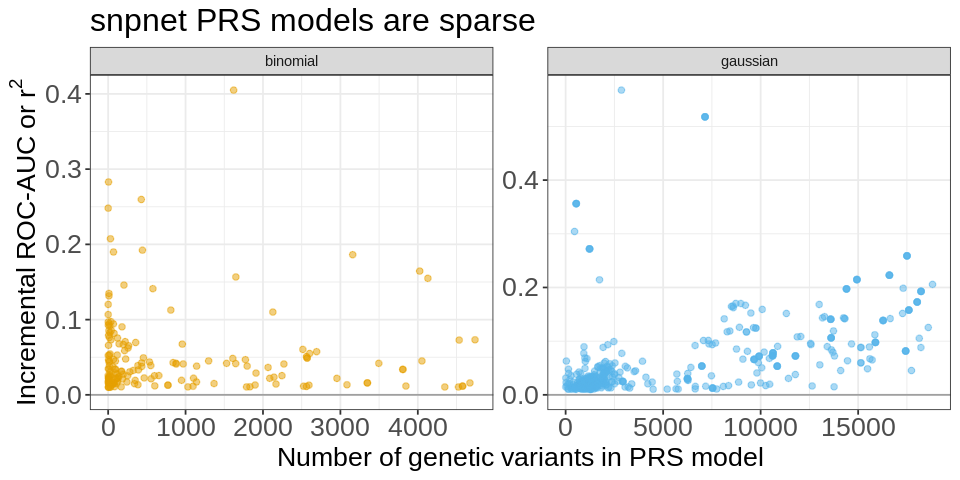

In [511]:
options(repr.plot.width=8, repr.plot.height=4)
bind_rows(
    filter(df, n_variables < 5000, family == 'binomial'),
    filter(df, n_variables < 20000, family == 'gaussian')
) %>% 
ggplot(aes(x=n_variables, y=geno_delta, color=family)) +
geom_hline(yintercept = 0, color=mit.colors[['Lt.Gray']])+
geom_point(alpha=.5) + theme_bw() +
facet_wrap(~family, scales = "free") +
labs(
    title = 'snpnet PRS models are sparse',
    x = 'Number of genetic variants in PRS model',
    y = latex2exp::TeX('Incremental ROC-AUC or r^2')
) + 
theme(
    title = element_text(size=16),
    legend.title = element_text(size=14),
    legend.text  = element_text(size=12),
    axis.text=element_text(size=16), 
    axis.title=element_text(size=16),
    legend.position = 'none'
) +
scale_color_manual(breaks = c("binomial", 'gaussian'), values=c(unname(cb.colors[2]), unname(cb.colors[3])))
# -> p_sparse


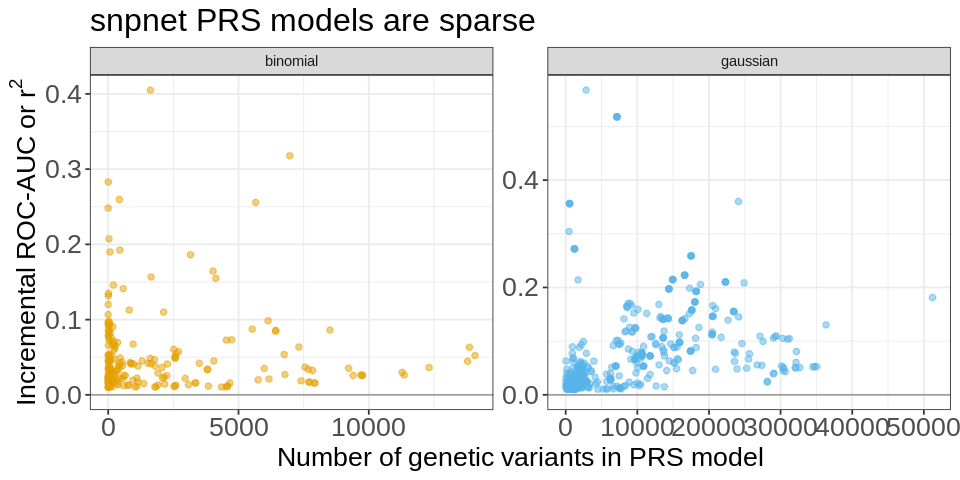

In [430]:
options(repr.plot.width=8, repr.plot.height=4)
df %>% 
# filter(n_variables < 5000) %>%
ggplot(aes(x=n_variables, y=geno_delta, color=family)) +
geom_hline(yintercept = 0, color=mit.colors[['Lt.Gray']])+
geom_point(alpha=.5) + theme_bw() +
facet_wrap(~family, scales = "free") +
labs(
    title = 'snpnet PRS models are sparse',
    x = 'Number of genetic variants in PRS model',
    y = latex2exp::TeX('Incremental ROC-AUC or r^2')
) + 
theme(
    title = element_text(size=16),
    legend.title = element_text(size=14),
    legend.text  = element_text(size=12),
    axis.text=element_text(size=16), 
    axis.title=element_text(size=16),
    legend.position = 'none'
) +
scale_color_manual(breaks = c("binomial", 'gaussian'), values=c(unname(cb.colors[2]), unname(cb.colors[3])))
# -> p_sparse


In [374]:
ggsave('plots/p_sparse.pdf', p_sparse, width=12, height=6)
ggsave('plots/p_sparse.png', p_sparse, width=12, height=6)


In [143]:
for(f in c('binomial', 'gaussian')){
    for(m in c('pearson', 'spearman')){
        message(sprintf('%s %s', f, m))
        cor.test(
            df %>% filter(family==f) %>% pull(n_variables),
            df %>% filter(family==f) %>% pull(geno_delta),
            method = m
        ) %>% print()
    }    
}


binomial pearson




	Pearson's product-moment correlation

data:  df %>% filter(family == f) %>% pull(n_variables) and df %>% filter(family == f) %>% pull(geno_delta)
t = -0.25008, df = 206, p-value = 0.8028
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1530995  0.1189018
sample estimates:
        cor 
-0.01742117 



binomial spearman

Warning message in cor.test.default(df %>% filter(family == f) %>% pull(n_variables), :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  df %>% filter(family == f) %>% pull(n_variables) and df %>% filter(family == f) %>% pull(geno_delta)
S = 1561642, p-value = 0.5542
alternative hypothesis: true rho is not equal to 0
sample estimates:
        rho 
-0.04124455 



gaussian pearson




	Pearson's product-moment correlation

data:  df %>% filter(family == f) %>% pull(n_variables) and df %>% filter(family == f) %>% pull(geno_delta)
t = 9.0086, df = 509, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.2935288 0.4433093
sample estimates:
     cor 
0.370828 



gaussian spearman

Warning message in cor.test.default(df %>% filter(family == f) %>% pull(n_variables), :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  df %>% filter(family == f) %>% pull(n_variables) and df %>% filter(family == f) %>% pull(geno_delta)
S = 7479952, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.6636519 



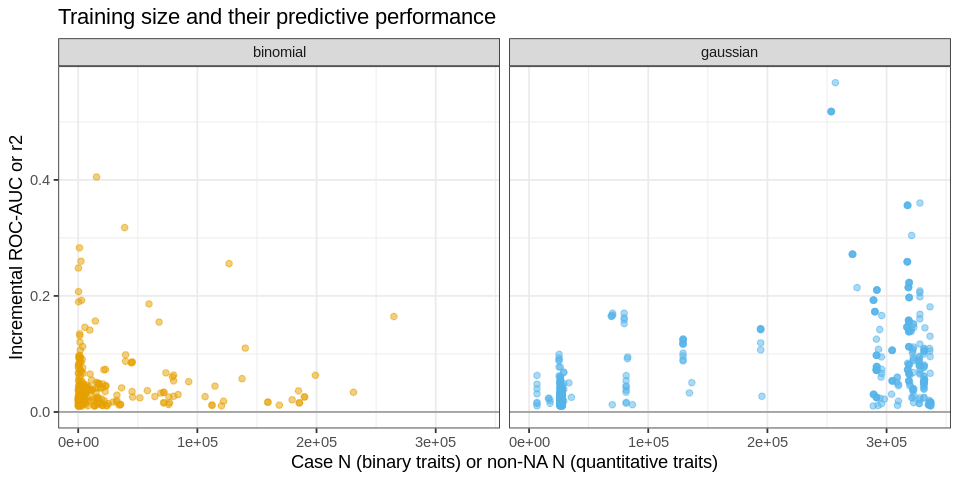

In [201]:
df %>% 
ggplot(aes(x=GBE_N, y=geno_delta, color=family)) +
geom_hline(yintercept = 0, color=mit.colors[['Lt.Gray']])+
geom_point(alpha=.5) + theme_bw() +
facet_wrap(~family) +
labs(
    title = 'Training size and their predictive performance',
    x = 'Case N (binary traits) or non-NA N (quantitative traits)',
    y = 'Incremental ROC-AUC or r2'
) + theme(legend.position = 'none') +
scale_color_manual(breaks = c("binomial", 'gaussian'), values=c(unname(cb.colors[2]), unname(cb.colors[3])))


In [144]:
for(f in c('binomial', 'gaussian')){
    for(m in c('pearson', 'spearman')){
        message(sprintf('%s %s', f, m))
        cor.test(
            df %>% filter(family==f) %>% pull(GBE_N),
            df %>% filter(family==f) %>% pull(geno_delta),
            method = m
        ) %>% print()
    }    
}


binomial pearson




	Pearson's product-moment correlation

data:  df %>% filter(family == f) %>% pull(GBE_N) and df %>% filter(family == f) %>% pull(geno_delta)
t = -0.43188, df = 206, p-value = 0.6663
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1654409  0.1063998
sample estimates:
        cor 
-0.03007673 



binomial spearman

Warning message in cor.test.default(df %>% filter(family == f) %>% pull(GBE_N), :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  df %>% filter(family == f) %>% pull(GBE_N) and df %>% filter(family == f) %>% pull(geno_delta)
S = 1665199, p-value = 0.1128
alternative hypothesis: true rho is not equal to 0
sample estimates:
       rho 
-0.1102926 



gaussian pearson




	Pearson's product-moment correlation

data:  df %>% filter(family == f) %>% pull(GBE_N) and df %>% filter(family == f) %>% pull(geno_delta)
t = 11.901, df = 509, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.3958606 0.5317984
sample estimates:
      cor 
0.4665803 



gaussian spearman

Warning message in cor.test.default(df %>% filter(family == f) %>% pull(GBE_N), :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  df %>% filter(family == f) %>% pull(GBE_N) and df %>% filter(family == f) %>% pull(geno_delta)
S = 11897248, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
     rho 
0.465021 



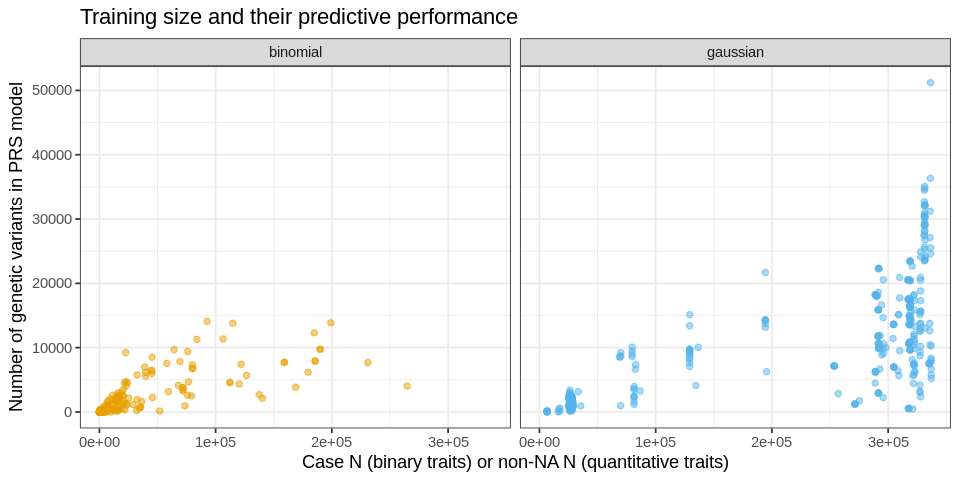

In [202]:
df %>% 
ggplot(aes(x=GBE_N, y=n_variables, color=family)) +
geom_point(alpha=.5) + theme_bw() +
facet_wrap(~family) +
labs(
    title = 'Training size and their predictive performance',
    x = 'Case N (binary traits) or non-NA N (quantitative traits)',
    y = 'Number of genetic variants in PRS model'
) + theme(legend.position = 'none') +
scale_color_manual(breaks = c("binomial", 'gaussian'), values=c(unname(cb.colors[2]), unname(cb.colors[3])))


In [145]:
for(f in c('binomial', 'gaussian')){
    for(m in c('pearson', 'spearman')){
        message(sprintf('%s %s', f, m))
        cor.test(
            df %>% filter(family==f) %>% pull(GBE_N),
            df %>% filter(family==f) %>% pull(n_variables),
            method = m
        ) %>% print()
    }    
}


binomial pearson




	Pearson's product-moment correlation

data:  df %>% filter(family == f) %>% pull(GBE_N) and df %>% filter(family == f) %>% pull(n_variables)
t = 16.423, df = 206, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.6873415 0.8064105
sample estimates:
      cor 
0.7529744 



binomial spearman

Warning message in cor.test.default(df %>% filter(family == f) %>% pull(GBE_N), :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  df %>% filter(family == f) %>% pull(GBE_N) and df %>% filter(family == f) %>% pull(n_variables)
S = 168290, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.8877906 



gaussian pearson




	Pearson's product-moment correlation

data:  df %>% filter(family == f) %>% pull(GBE_N) and df %>% filter(family == f) %>% pull(n_variables)
t = 26.863, df = 509, p-value < 2.2e-16
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.7273347 0.7994057
sample estimates:
      cor 
0.7657638 



gaussian spearman

Warning message in cor.test.default(df %>% filter(family == f) %>% pull(GBE_N), :
“Cannot compute exact p-value with ties”



	Spearman's rank correlation rho

data:  df %>% filter(family == f) %>% pull(GBE_N) and df %>% filter(family == f) %>% pull(n_variables)
S = 4855617, p-value < 2.2e-16
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.7816593 



In [150]:
df %>% filter(GBE_category == 'Disease_outcome') %>% 
head()

GBE_ID,GBE_category,GBE_ID_prefix,split,geno,covar,geno_covar,geno_delta,n_variables,family,n,case_n,control_n,GBE_N,GBE_NAME,GBE_short_name,Units_of_measurement,rank_geno_delta_per_family
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<lgl>,<int>
HC702,Disease_outcome,HC,test,0.8869725,0.6223703,0.9052945,0.2829243,5,binomial,NA,215,67210,1058,TTE_disorders_of_porphyrin_and_bilirubin_metabolism,TTE disorders of porphyrin and bilirubin metabolism,NA,3
HC303,Disease_outcome,HC,test,0.8286689,0.5744728,0.8341481,0.2596752,428,binomial,NA,451,66974,2300,malabsorption/coeliac_disease,Malabsorption/coeliac disease,NA,4
HC26,Disease_outcome,HC,test,0.7858162,0.5682619,0.8163905,0.2481287,1,binomial,NA,40,67385,186,iritis,Iritis,NA,6
HC413,Disease_outcome,HC,test,0.6986729,0.4741523,0.6816052,0.2074529,30,binomial,NA,59,67366,304,hereditary/genetic_haematological_disorder,Genetic haematological disorder,NA,7
HC1132,Disease_outcome,HC,test,0.7508450,0.5667454,0.7590588,0.1923135,443,binomial,NA,553,66872,2849,TTE_intestinal_malabsorption,TTE intestinal malabsorption,NA,8
HC337,Disease_outcome,HC,test,0.7654339,0.5757536,0.7656181,0.1898645,69,binomial,NA,58,67367,344,type_1_diabetes,Type 1 diabetes,NA,9


In [223]:
df %>% filter(GBE_category == 'Disease_outcome') %>% dim()

[1] 124  18

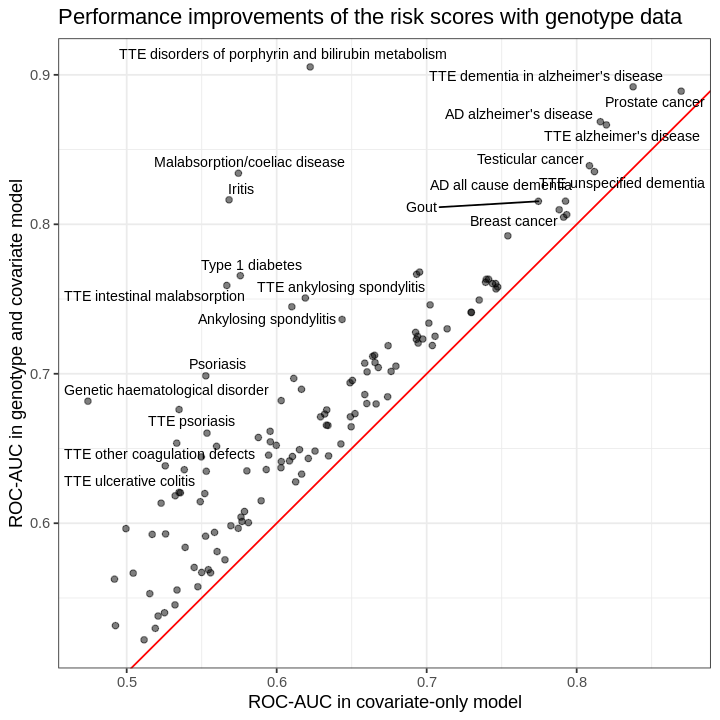

In [226]:
options(repr.plot.width=6, repr.plot.height=6)
df %>% filter(GBE_category %in% c('Disease_outcome', 'cancer')) %>% 
mutate(repel_label = if_else(rank(-geno_delta) <= 12 | rank(-geno_covar) <= 12, GBE_short_name, '')) %>%
ggplot(aes(x = covar, y = geno_covar, label=repel_label)) +
geom_abline(slope=1, intercept = 0, color='red') +
geom_point(alpha=.5) + theme_bw() +
labs(
    title='Performance improvements of the risk scores with genotype data',
    x = 'ROC-AUC in covariate-only model',
    y = 'ROC-AUC in genotype and covariate model'
) + 
ggrepel::geom_text_repel(size=3)


In [320]:
p_binary_color_group <- data.frame(
    GBE_category = c('Disease_outcome', 'Health_and_medical_history', 'Lifestyle_and_environment', 'Psychosocial_factors', 'cancer', 'Others'),
    Trait_category = c('Disease outcome', 'Health and medical history', 'Lifestyle and environment', 'Psychosocial factors', 'Cancer', 'Others'),
    ggrepel = c(T, T, F, T, T, F),
    plot_color = c(unname(cb.colors[3]), unname(cb.colors[2]), unname(cb.colors[5]), unname(cb.colors[4]), unname(cb.colors[7]), mit.colors[['Lt.Gray']]),
    stringsAsFactors=F
)

In [523]:
options(repr.plot.width=6, repr.plot.height=6)
df %>% filter(family == 'binomial') %>% 
left_join(p_binary_color_group, by='GBE_category') %>%
replace_na(list(Trait_category = 'Others', ggrepel=F)) %>%
mutate(GBE_short_name = if_else(ggrepel, GBE_short_name, '')) %>%
group_by(ggrepel) %>%
mutate(
    repel_label = if_else(
        rank(-geno_delta) <= 3 | rank(-geno_covar) <= 3 | GBE_ID %in% c('HC201', 'HC382'), 
        str_replace(GBE_short_name, '^TTE\\s+', ''), ''
    )
) %>%
ungroup() %>%
ggplot(aes(x = covar, y = geno_covar, label=repel_label, color=Trait_category)) +
geom_abline(slope=1, intercept = 0, color=mit.colors[['Lt.Gray']]) +
geom_point() + theme_bw() +
labs(
    color = 'Trait category',
    title='208 Binary traits',
    x = 'ROC-AUC in covariate-only model',
    y = 'ROC-AUC in genotype and covariate model'
) + 
ggrepel::geom_text_repel(size=5, force=3, color='black') +
theme(
    title = element_text(size=16),
    legend.title = element_text(size=14),
    legend.text  = element_text(size=12),
    axis.text=element_text(size=16), 
    axis.title=element_text(size=16),
    legend.position = c(.75, .2)
) +
scale_color_manual(
    breaks = p_binary_color_group %>% pull(Trait_category), 
    values = p_binary_color_group %>% pull(plot_color)
) -> p_binary


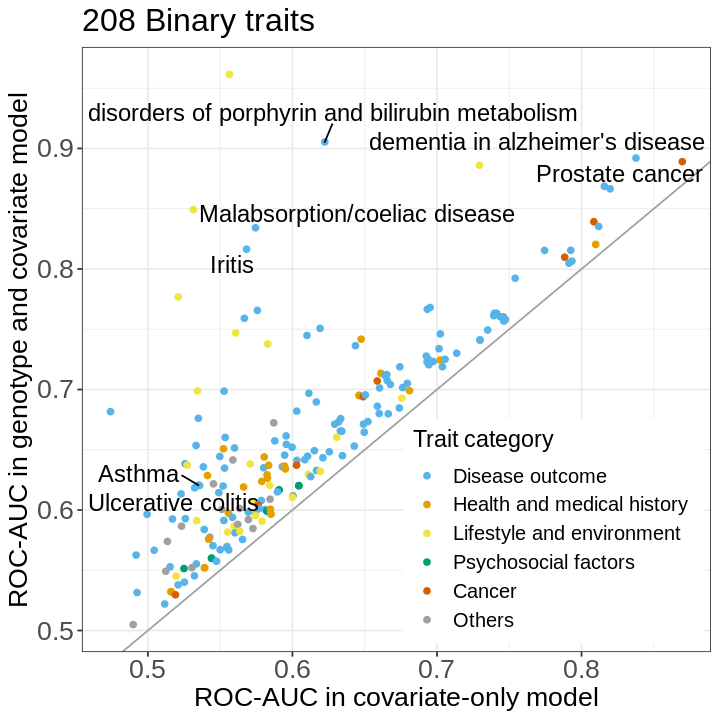

In [524]:
p_binary

In [525]:
ggsave('plots/p_binary.pdf', p_binary, width=6, height=6)
ggsave('plots/p_binary.png', p_binary, width=6, height=6)


In [356]:
p_quantitative_color_group <- data.frame(
    GBE_category = c(
        'Diffusion_brain_MRI', 'T1_structural_brain_MRI', 
        'Biomarkers', 'Blood_assays',
        'Anthropometry', 'Bone-densitometry_of_heel', 'Others'),
    Trait_category = c(
        'Brain MRI', 'Brain MRI',
        'Biomarkers', 'Blood assays',
        'Anthropometry', 'Bone-densitometry of heel', 'Others'),
    ggrepel = c(T, T, F, T, T, T, F),
    plot_color = c(
        unname(cb.colors[5]), unname(cb.colors[5]),
        unname(cb.colors[4]), unname(cb.colors[3]),
        unname(cb.colors[2]), unname(cb.colors[7]), mit.colors[['Lt.Gray']]),
    stringsAsFactors=F
)

In [485]:
options(repr.plot.width=6, repr.plot.height=6)
df %>% filter(family != 'binomial') %>% 
left_join(p_quantitative_color_group, by='GBE_category') %>%
replace_na(list(Trait_category = 'Others', ggrepel=F)) %>%
mutate(GBE_short_name = if_else(ggrepel, GBE_short_name, '')) %>%
group_by(ggrepel) %>%
mutate(
    repel_label = if_else(rank(-geno_delta) <= 4 | rank(-geno_covar) <= 4, GBE_short_name, '')
) %>%
ungroup() %>%
ggplot(aes(x = covar, y = geno_covar, label=repel_label, color=Trait_category)) +
geom_abline(slope=1, intercept = 0, color=mit.colors[['Lt.Gray']]) +
geom_point() + theme_bw() +
labs(
    color = 'Trait category',
    title='511 Quantitative traits',
    x = latex2exp::TeX('r^2 in covariate-only model'),
    y = latex2exp::TeX('r^2 in genotype and covariate model')
) + 
ggrepel::geom_text_repel(size=5, force=4, color='black') +
theme(
    title = element_text(size=16),
    legend.title = element_text(size=14),
    legend.text  = element_text(size=12),
    axis.text=element_text(size=16), 
    axis.title=element_text(size=16),
    legend.position = c(.75, .2)
) +
theme(legend.position = c(.75, .2)) +
scale_color_manual(
    breaks = p_quantitative_color_group %>% pull(Trait_category), 
    values = p_quantitative_color_group %>% pull(plot_color)
) -> p_quantitative


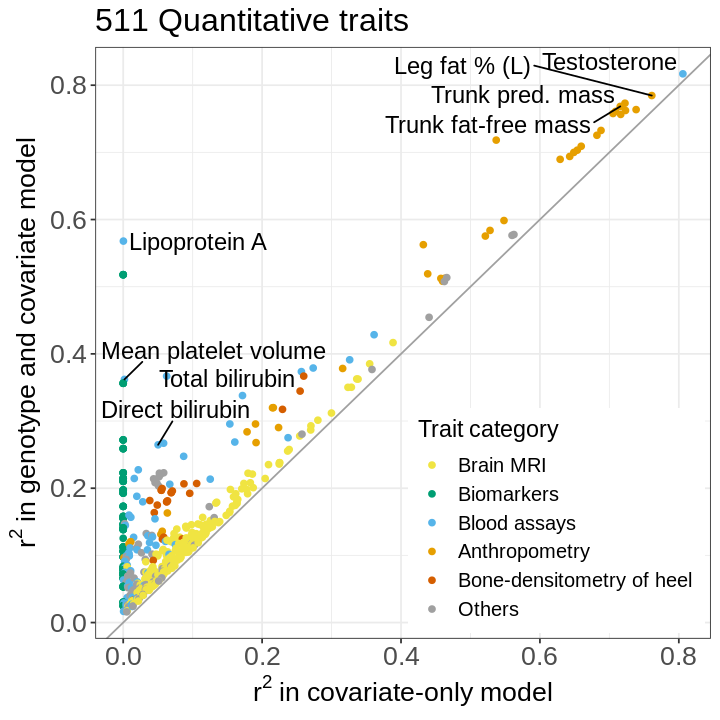

In [486]:
p_quantitative

In [487]:
ggsave('plots/p_quantitative.pdf', p_quantitative, width=6, height=6)
ggsave('plots/p_quantitative.png', p_quantitative, width=6, height=6)

In [313]:
df %>% filter(family != 'binomial') %>% count(GBE_category) %>%
arrange(-n)

GBE_category,n
<chr>,<int>
Diffusion_brain_MRI,135
Biomarkers,114
T1_structural_brain_MRI,72
Blood_assays,64
Anthropometry,38
Bone-densitometry_of_heel,23
Eye_measures,18
Lifestyle_and_environment,12
Susceptibility_weighted_brain_MRI,6


In [229]:
df %>% filter(family == 'binomial', ! GBE_category %in% c('Disease_outcome', 'cancer')) %>% 
head(20)

GBE_ID,GBE_category,GBE_ID_prefix,split,geno,covar,geno_covar,geno_delta,n_variables,family,n,case_n,control_n,GBE_N,GBE_NAME,GBE_short_name,Units_of_measurement,rank_geno_delta_per_family
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<lgl>,<int>
BIN_FC2001747,Lifestyle_and_environment,BIN_FC,test,0.9606803,0.5563726,0.9613973,0.40502477,1621,binomial,NA,3058,64228,15411,"Hair_colour_(natural,_before_greying)_red","Hair colour (natural, before greying) red",NA,1
BIN_FC1001747,Lifestyle_and_environment,BIN_FC,test,0.8475395,0.5314784,0.8493170,0.31783862,6970,binomial,NA,7914,59372,38964,"Hair_colour_(natural,_before_greying)_blonde","Hair colour (natural, before greying) blonde",NA,2
BIN_FC4001747,Lifestyle_and_environment,BIN_FC,test,0.7758804,0.5210383,0.7767690,0.25573064,5662,binomial,NA,25313,41973,126631,"Hair_colour_(natural,_before_greying)_dark_brown","Hair colour (natural, before greying) dark brown",NA,5
BIN_FC40001727,Lifestyle_and_environment,BIN_FC,test,0.7408455,0.5607203,0.7469635,0.18624330,3159,binomial,NA,11988,54199,59404,"Ease_of_skin_tanning_(Never_tan,_only_burn)","Ease of skin tanning (Never tan, only burn)",NA,10
BIN_FC7001747,Lifestyle_and_environment,BIN_FC,test,0.6951117,0.5343223,0.6988177,0.16449548,4024,binomial,NA,52905,14381,264882,"Hair_colour_(natural,_before_greying)_brown","Hair colour (natural, before greying) brown",NA,11
BIN_FC5001747,Lifestyle_and_environment,BIN_FC,test,0.8305383,0.7293906,0.8860860,0.15669543,1649,binomial,NA,2842,64444,14386,"Hair_colour_(natural,_before_greying)_black","Hair colour (natural, before greying) black",NA,12
BIN_FC10001727,Lifestyle_and_environment,BIN_FC,test,0.7173240,0.5829592,0.7378374,0.15487819,4130,binomial,NA,13602,52585,67914,Ease_of_skin_tanning_(Get_very_tanned),Ease of skin tanning (Get very tanned),NA,13
BIN_FC3001747,Lifestyle_and_environment,BIN_FC,test,0.6344946,0.5272664,0.6372785,0.11001208,2127,binomial,NA,27978,39308,140221,"Hair_colour_(natural,_before_greying)_light_brown","Hair colour (natural, before greying) light brown",NA,20
BIN_FC4006152,Health_and_medical_history,BIN_FC,test,0.6426526,0.5523096,0.6507998,0.09849025,6139,binomial,NA,7869,46067,39753,asthma_diagnosed_by_doctor,Asthma diagnosed by doctor,NA,22


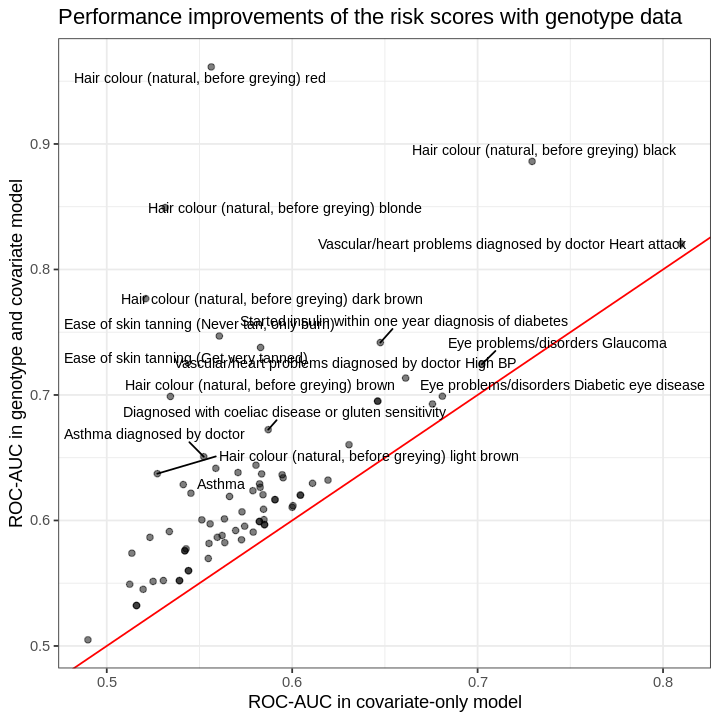

In [227]:
options(repr.plot.width=6, repr.plot.height=6)
df %>% filter(family == 'binomial', ! GBE_category %in% c('Disease_outcome', 'cancer')) %>% 
mutate(repel_label = if_else(rank(-geno_delta) <= 12 | rank(-geno_covar) <= 12, GBE_short_name, '')) %>%
ggplot(aes(x = covar, y = geno_covar, label=repel_label)) +
geom_abline(slope=1, intercept = 0, color='red') +
geom_point(alpha=.5) + theme_bw() +
labs(
    title='Performance improvements of the risk scores with genotype data',
    x = 'ROC-AUC in covariate-only model',
    y = 'ROC-AUC in genotype and covariate model'
) + 
ggrepel::geom_text_repel(size=3)
